In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h5py
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error

In [ ]:
# Load metadata
df = pd.read_csv("clean_output_with_roi.csv")

In [ ]:

mri_volumes = {}

# Load the saved original shape
original_shape = tuple(np.load("original_shape.npy"))

with h5py.File("25-brain_overlayed_new.h5", "r") as overlay_file:
    for _, row in tqdm(df.iterrows(), total=len(df), desc="Reconstructing Volumes and Extracting ROI features"):
        subject_id = str(row["ID"]).zfill(3)
        if subject_id in overlay_file:
            overlay_data = overlay_file[subject_id]["image_array"][:]
            
            # Reconstruct full 3D volume
            reconstructed_volume = np.zeros(original_shape)
            reconstructed_volume[brain_mask == 1] = overlay_data
            
            # Store 3D MRI volume for later use
            mri_volumes[subject_id] = reconstructed_volume  


Reconstructing Volumes and Extracting ROI features: 100%|██████████| 93/93 [00:00<00:00, 950.76it/s]


In [ ]:

X_mri_list = []
X_demo_list = []
y_list = []

for _, row in df.iterrows():
    subject_id = str(row["ID"]).zfill(3)
    
    if subject_id in mri_volumes:
        volume = mri_volumes[subject_id]
        X_mri_list.append(volume)
        
        # Demographic features: age, sex, HOC
        age = row['age']
        sex = row['sex']  #  0 = female, 1 = male, or vice versa
        hoc = row['HOC']  # History of Concussion
        X_demo_list.append([age, sex, hoc])
        
        y_list.append(row['log_dRecov'])


# Stack MRI volumes into a 5D tensor: (n_samples, 1, D, H, W)
X_3d_array = np.stack(X_mri_list)
X_3d_tensor = torch.tensor(X_3d_array).unsqueeze(1).float()

# Stack demographics into a 2D tensor: (n_samples, 3)
X_demo_array = np.stack(X_demo_list)
X_demo_tensor = torch.tensor(X_demo_array).float()

# Stack targets into a 1D tensor: (n_samples,)
y_array = np.array(y_list)
y_tensor = torch.tensor(y_array).float()


In [ ]:


class CNNWithDemographics(nn.Module):
    def __init__(self, mri_input_shape, demographic_dim):
        super(CNNWithDemographics, self).__init__()
        self.conv1 = nn.Conv3d(1, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool3d(2)
        self.conv2 = nn.Conv3d(16, 32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool3d(2)

        # Compute flattened CNN output size
        self.flattened_size = 32 * (mri_input_shape[0] // 4) * (mri_input_shape[1] // 4) * (mri_input_shape[2] // 4)
        self.fc_cnn = nn.Linear(self.flattened_size, 64)
        self.fc_demo = nn.Linear(demographic_dim, 16)
        self.fc_combined = nn.Linear(64 + 16, 1)

    def forward(self, mri, demo):
        x = self.pool1(torch.relu(self.conv1(mri)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        self.features = x 
        x = torch.relu(self.fc_cnn(x))
        d = torch.relu(self.fc_demo(demo))
        x = torch.cat([x, d], dim=1)
        return self.fc_combined(x)

In [ ]:
def cnn_demo_pca_lasso_kfold(X_tensor, X_demo_tensor, y_tensor,
                              model_class, n_components=10, n_splits=5):
    """
    Perform PCA + LASSO with K-Fold CV using CNN + demographic features.

    Args:
        X_tensor (torch.Tensor): MRI tensor [N, 1, D, H, W]
        X_demo_tensor (torch.Tensor): Demographic features [N, D]
        y_tensor (torch.Tensor): Target tensor [N, 1]
        model_class (nn.Module): CNN class with .features attribute
        n_components (int): Number of PCA components
        n_splits (int): Number of folds for KFold CV

    Returns:
        rmse (float): Average RMSE across folds
        truths (list): Ground truth values
        preds (list): Predicted values
    """
    assert model_class is not None, "Please provide a CNN model class."

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model_class(
        mri_input_shape=X_tensor.shape[2:],
        demographic_dim=X_demo_tensor.shape[1]
    ).to(device)
    model.eval()

    # Step 1: Extract CNN features
    cnn_features = []
    with torch.no_grad():
        for i in range(len(X_tensor)):
            mri = X_tensor[i].unsqueeze(0).to(device)           # [1, 1, D, H, W]
            demo = X_demo_tensor[i].unsqueeze(0).to(device)     # [1, D]
            _ = model(mri, demo)
            cnn_features.append(model.features.cpu().numpy().flatten())
    cnn_features = np.array(cnn_features)

    # Step 2: Combine with demographics
    demo_features = X_demo_tensor.cpu().numpy()
    combined_features = np.hstack((cnn_features, demo_features))
    y_array = y_tensor.cpu().numpy().flatten()

    # Step 3: K-Fold CV — PCA + LASSO *per fold*
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    preds, truths = [], []

    for train_idx, test_idx in kf.split(combined_features):
        X_train, X_test = combined_features[train_idx], combined_features[test_idx]
        y_train, y_test = y_array[train_idx], y_array[test_idx]

        pca = PCA(n_components=n_components)
        X_train_pca = pca.fit_transform(X_train)
        X_test_pca = pca.transform(X_test)

        lasso = Lasso(alpha=0.01, max_iter=10000)
        lasso.fit(X_train_pca, y_train)
        pred = lasso.predict(X_test_pca)

        preds.extend(pred)
        truths.extend(y_test)

    rmse = np.sqrt(mean_squared_error(truths, preds))
    print(f"✅ K-Fold RMSE (CNN + Demographics + PCA + LASSO): {rmse:.4f}")
    return rmse, truths, preds

In [ ]:
from sklearn.model_selection import KFold
rmses_with_demo, y_true_demo_3cnn, y_pred_demo_3cnn = rmse_lasso_pca_demo, y_true_comb, y_pred_comb = cnn_demo_pca_lasso_kfold(
    X_tensor=X_3d_tensor,
    X_demo_tensor=X_demo_tensor,
    y_tensor=y_tensor,
    model_class=CNNWithDemographics,   
    n_components=10,
    n_splits=5
)

✅ K-Fold RMSE (CNN + Demographics + PCA + LASSO): 0.9983


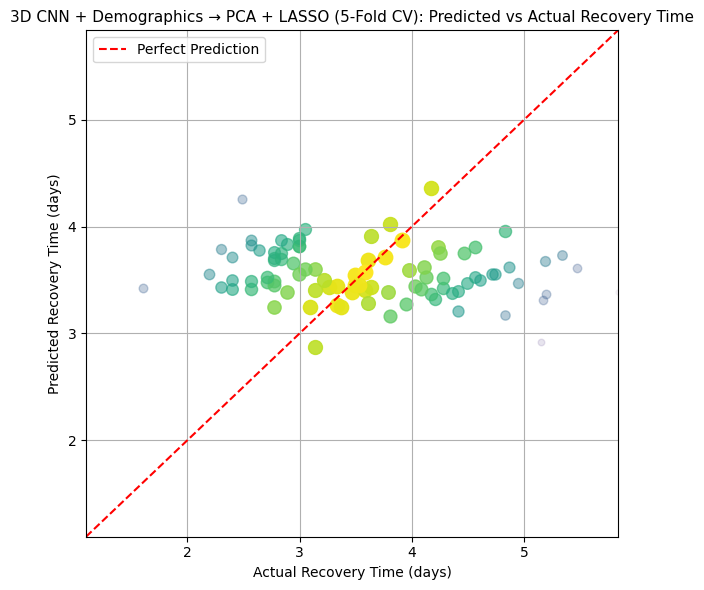

In [ ]:
y_true_demo = np.array(y_true_demo_3cnn)
y_pred_demo = np.array(y_pred_demo_3cnn)

residuals = np.abs(y_true_demo - y_pred_demo)

residuals_norm = (residuals - residuals.min()) / (residuals.max() - residuals.min() + 1e-8)
sizes = 100 * (1 - residuals_norm) + 10       
alphas = 1 - residuals_norm                 

colors = plt.cm.viridis(1 - residuals_norm)  

plt.figure(figsize=(6, 6))
for i in range(len(y_true_demo)):
    plt.scatter(y_true_demo[i], y_pred_demo[i], 
                s=sizes[i], 
                c=[colors[i]], 
                alpha=alphas[i])

plt.plot([y_true_demo.min(), y_true_demo.max()], 
         [y_true_demo.min(), y_true_demo.max()], 
         'r--', label='Perfect Prediction')

plt.xlabel("Actual Recovery Time (days)")
plt.ylabel("Predicted Recovery Time (days)")
plt.title("3D CNN + Demographics → PCA + LASSO (5-Fold CV): Predicted vs Actual Recovery Time", fontsize=11)
plt.xlim(y_true_demo.min(), y_true_demo.max())
plt.ylim(y_true_demo.min(), y_true_demo.max())
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
